In [158]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

In [26]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [51]:
df_markers = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df_markers = df_markers.append(df_)
    
df_markers.to_csv('all_markers.csv')

# Univariate analysis: On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [147]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .query("mind != 'sMW'") #if you want to test against just one of the mw
    .drop(['participant', 'probe', 'mind'], axis = 1) # drop mind or mind2 also
)

AUC wSMI = 0.5467684755931279
AUC p_e = 0.5368602854285973
AUC k = 0.52267218131685
AUC b = 0.4734721085961882
AUC b_n = 0.4415962185255886
AUC g = 0.5375268914947126
AUC g_n = 0.5631457746265491
AUC t = 0.49943944489894854
AUC t_n = 0.5350877192982457
AUC d = 0.46039753961761054
AUC d_n = 0.44747447201769536
AUC a_n = 0.514756234281732
AUC a = 0.5035602823985699
AUC CNV = 0.493273338787383
AUC P1 = 0.538208647698694
AUC P3a = 0.4902281610762658
AUC P3b = 0.5513741175044693


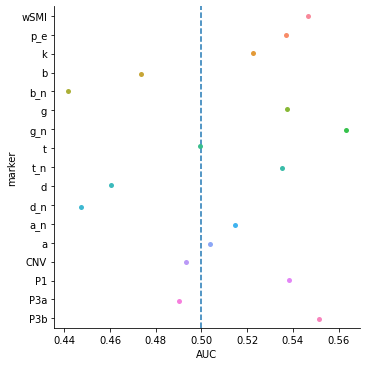

In [148]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC wSMI = 0.643288084464555
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC p_e = 0.5165912518853696
{'SVM__C': 1000000.0, 'SVM__gamma': 0.1}
AUC k = 0.6304675716440422
{'SVM__C': 1000000.0, 'SVM__gamma': 0.01}
AUC b = 0.3996983408748115
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC b_n = 0.37669683257918557
{'SVM__C': 10, 'SVM__gamma': 0.1}
AUC g = 0.39366515837104077
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC g_n = 0.5546757164404224
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC t = 0.448340874811463
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC t_n = 0.5407239819004525
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC d = 0.5350678733031674
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC d_n = 0.41968325791855204
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC a_n = 0.4777526395173454
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC a = 0.5697586726998493
{'SVM__C': 100, 'SVM__gamma': 0.1}
AUC CNV = 0.5739064856711916
{'SVM__C': 0.001, 'SVM__gamma': 0.1}
AUC P1 = 0.49962292609351433
{'SVM__C': 0.001

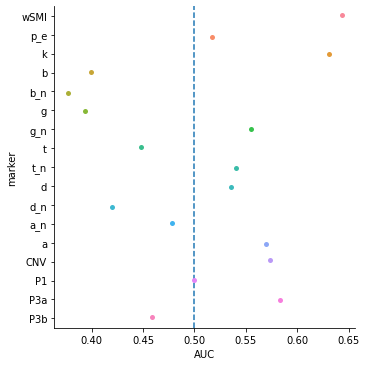

In [160]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
    parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
    grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
    grid.fit(X_train, y_train)
    y_proba = grid.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,0])
    print(grid.best_params_)
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# Univariate analysis: dMW Vs sMW
This will be only performed in SC as they have more trials

In [157]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe'], axis = 1)
)

AUC wSMI = 0.4978568548061878
AUC p_e = 0.43689513332150404
AUC k = 0.5276337651025116
AUC b = 0.4377739422192829
AUC b_n = 0.49214008033165035
AUC g = 0.4914464536318617
AUC g_n = 0.5434336134724889
AUC t = 0.45527462778055583
AUC t_n = 0.4958792121691159
AUC d = 0.4852005871630668
AUC d_n = 0.5460074524543094
AUC a_n = 0.4444592131369671
AUC a = 0.42691723259077635
AUC CNV = 0.5147516655106221
AUC P1 = 0.512903069701418
AUC P3a = 0.5384285322536415
AUC P3b = 0.5195289790782831


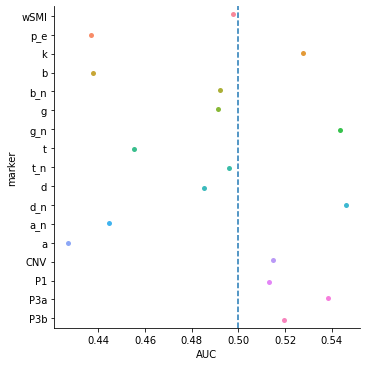

In [155]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = []
for i in markers:
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5281260787508267
AUC p_e = 0.5567728614520995
AUC k = 0.5506102301872792
AUC b = 0.5795505944219509
AUC b_n = 0.5429709805945833
AUC g = 0.5595612407852499
AUC g_n = 0.5694033197296469
AUC t = 0.5406326520736212
AUC t_n = 0.5340561031084154
AUC d = 0.5015475940832029
AUC d_n = 0.5410014033842531
AUC a_n = 0.5590953817366477
AUC a = 0.5730576032777894
AUC CNV = 0.547607955736938
AUC P1 = 0.4655344958301743
AUC P3a = 0.5414579065378349
AUC P3b = 0.46374719726420727
Index(['dMW', 'sMW'], dtype='object')


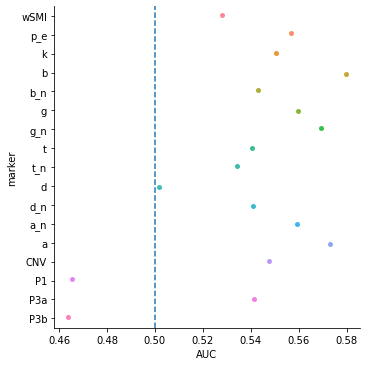

In [156]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = []
for i in markers:
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,1])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])
print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()